In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

from datetime import date
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect= True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
#Measurement table
Measurement =  Base.classes.measurement
#Station Table
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

In [11]:
# Get a list of column names and types for measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Get a list of column names and types for station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

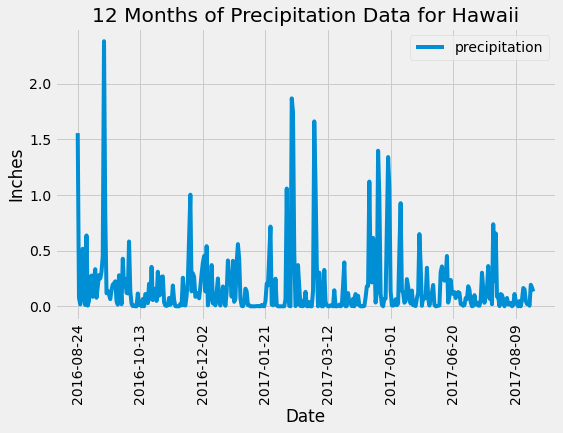

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#twelve_months = date.today() + relativedelta(months=+12)
#last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() + relativedelta(months=+12)

# Calculate the date 1 year ago from the last data point in the database

#locate and define the most recent date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = dt.date(2017,8,23)

#locate and define 12 month date
twelve_months = last_date - dt.timedelta(weeks=52)

#query to run through 12 months of results
session.query(Measurement.date).\
    filter(Measurement.date >= twelve_months).\
    order_by(Measurement.date.desc()).all()

# Perform a query to retrieve the data and precipitation scores
prcp = [Measurement.date,
        func.avg(Measurement.prcp)]

#12 month of precp query data
prcp_twelve_mon = session.query(*prcp).\
    filter(Measurement.date >= twelve_months).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
prcp_twelve_mon

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_twelve_mon, columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(8,5))
plt.xlabel("Date")
plt.xticks(rotation = 90)
plt.ylabel("Inches")
plt.title("12 Months of Precipitation Data for Hawaii")
plt.show()

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_summary = prcp_df.describe()
prcp_summary

,precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(func.distinct(Measurement.station)).count()

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#preform a query to get the stations and row counts
active_stations = session.query(Measurement.station, func.count(Measurement.prcp)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.prcp).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

most_active_station = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').all()
#print(most_active_station)
most_active_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

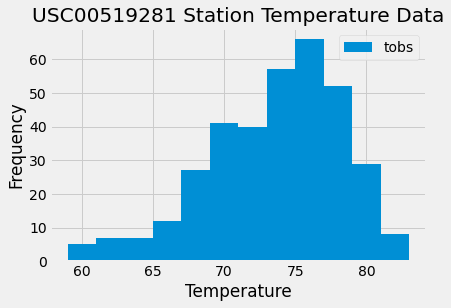

In [39]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps_ma = session.query(Measurement.tobs).\
            filter(Measurement.date >= twelve_months, Measurement.station == 'USC00519281').all()

temps = np.array(temps_ma)

#histogram
plt.hist(temps, bins = 12, label = 'tobs')
plt.xlabel("Temperature") 
plt.ylabel("Frequency") 
plt.title("USC00519281 Station Temperature Data")
plt.legend(loc="upper right") 
plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
